# Create Cell Cycle Binary_correlation_plot

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import gseapy as gp
import re

import cptac
import cptac.utils as u

import plot_utils as ut

In [2]:
# Returns a dataframe with proteomics and mutation type

# all_prot: list of trans genes

def all_prot_format_df(cancer_object, all_prot, gene_in = 'PTEN'):
    mut_type = cancer_object.get_genotype_all_vars(gene_in)
    
    if cancer_object.get_cancer_type() not in ('luad'):
        # Keep only tumor samples from proteomics
        prot_and_mutations = cancer_object.join_omics_to_mutations(
            mutations_genes = [gene_in], omics_df_name = 'proteomics', omics_genes = all_prot)
        # Reduce a multiindex 
        if isinstance(prot_and_mutations.keys(), pd.core.indexes.multi.MultiIndex):
            prot_and_mutations = cancer_object.reduce_multiindex(prot_and_mutations, levels_to_drop = 1)
        prot_and_mutations = prot_and_mutations[prot_and_mutations.Sample_Status == "Tumor"] # drop Normal samples

        # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
        mut_type = mut_type[['Mutation']] 
        prot_df = prot_and_mutations.iloc[:,:-4] # Keep only proteomics
        merged = prot_df.join(mut_type)
        
        # Keep only Wildtype and deletion
        compare = ['Wildtype_Tumor','Deletion']
        get = merged['Mutation'].isin(compare)
        del_wt = merged[get]
    
    
    # Luad has no somatic mutations for PTEN which changes some things
    else: 
        # get_genotype_all_vars add cnv data under the column PTEN
        mut_type = mut_type.drop(columns= gene_in)
        # different code because no somatic mutation data for pten (can't join to somatic mutations)
        omics = cancer_object.join_omics_to_omics(df1_name = 'CNV', df2_name='proteomics',genes1= gene_in, 
            genes2= all_prot)
        omics = cancer_object.reduce_multiindex(omics, levels_to_drop = 1, flatten = True)
        omics = omics.drop(columns='PTEN_CNV')
        # Get only tumor samples
        p = cancer_object.get_proteomics(tissue_type='tumor')
        tumor_ids = list(p.index)
        get = omics.index.isin(tumor_ids)
        omics = omics[get]
        # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
        merged = omics.join(mut_type) 
        # Keep only No_Mutation (wildtype) and deletion
        compare = ['No_Mutation','Deletion']
        get = merged['Mutation'].isin(compare)
        del_wt = merged[get]
        del_wt['Mutation'] = np.where(
            del_wt['Mutation'] == 'No_Mutation', 'Wildtype_Tumor', 'Deletion')

    return del_wt


# Select two cancers for the plot

In [3]:
ls = cptac.Lscc()
g = cptac.Gbm()

cptac warning: The LSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 1)


cptac warning: The GBM dataset is under publication embargo until March 01, 2021. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 2)


In [4]:
root = R'~\Github\WhenMutationsDontMatter\PTEN\Step_3_trans_effect\csv'
ls_df = pd.read_csv(root+R'\lscc_pval_medians.csv')
g_df = pd.read_csv(root+R'\gbm_pval_medians.csv')

# Calculate FDR-bh (lowest sig p-value = cutoff)

Gbm t-tests

In [5]:
gene = 'PTEN'
g_prot = g.get_proteomics()
g_prot_list = list(g_prot.columns)

g_del_wt = all_prot_format_df(g, g_prot_list, gene)
g_del_wt = g_del_wt.dropna(axis='columns', how='all')

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 72 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 394)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: C3L-01834 (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 394)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 82 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 11)


In [6]:
cols = list(g_del_wt.columns[:-1])
print(len(cols), 'genes')

# Get only sig genes
g_sig = u.wrap_ttest(g_del_wt, 'Mutation', cols, correction_method = 'fdr_bh')

# get_smallest p-value
cutoff_gbm = g_sig.P_Value[-1:]
cutoff_gbm

11141 genes


C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\Users\brittany henderson\Anaconda3\e

1886    0.008467
Name: P_Value, dtype: float64

Lscc t-tests

In [7]:
gene = 'PTEN'
ls_prot = ls.get_proteomics()
ls_prot = ls.reduce_multiindex(ls_prot, levels_to_drop = 1)
ls_prot_list = list(ls_prot.columns)

ls_del_wt = all_prot_format_df(ls, ls_prot_list, gene)
ls_del_wt = ls_del_wt.dropna(axis='columns', how='all')
ls_del_wt = ls_del_wt.loc[:,~ls_del_wt.columns.duplicated()]

cptac warning: Due to dropping the specified levels, dataframe now has 830 duplicated column headers. (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 3)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 99 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 394)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 201 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 11)
cptac warning: Due to dropping the specified levels, dataframe now has 830 duplicated column headers. (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 14)


In [8]:
ls_cols = list(ls_del_wt.columns[:-1])
print(len(ls_cols), 'genes')

# Get only sig sites
ls_sig = u.wrap_ttest(ls_del_wt, 'Mutation', ls_cols, correction_method = 'fdr_bh')

# get_smallest p-value
cutoff_ls = ls_sig.P_Value[-1:]
cutoff_ls

10863 genes


286    0.001318
Name: P_Value, dtype: float64

# Create df with p-values for all genes in a pathway

In [9]:
rcc = pd.read_excel(root+R"\Reactome_cell_cycle.xlsx", sheet_name='cell_cycle')
rgs = pd.read_excel(root+R"\Reactome_cell_cycle.xlsx", sheet_name='g1_to_s')

In [10]:
reactome_cell_cycle = list(rcc.columns)
cell_cycle_list = reactome_cell_cycle[2:]

In [11]:
reactome_g1_to_s = list(rgs.columns)
g1_to_s_list = reactome_g1_to_s[2:]

In [12]:
len(cell_cycle_list)

674

In [13]:
# Merge dfs of both cancers and keep only genes in a complete pathway
merged = g_df.merge(ls_df, on ='Proteomics', how='outer')
merged = merged.replace(regex=True,to_replace='_proteomics', value='')
dna_bool = merged.Proteomics.isin(cell_cycle_list)
df = merged[dna_bool]
df.head()
len(df)

553

In [14]:
# Create pval only df for Color mapping
pval_df = df.drop(columns = ['Gbm_Median','Lscc_Median'])
pval_df = pval_df.set_index('Proteomics')
pval_df.head()

,Gbm_P_Value,Lscc_P_Value
Proteomics,,
DCTN1,1.016640e-08,0.048612
ACTR1A,3.600370e-08,0.021945
MAPK3,1.020660e-06,0.049822
DCTN3,2.683160e-06,0.021230
BRCC3,3.222041e-06,0.010810


# Create the color column based on significance in both cancers 

In [15]:
def Color(row):
    color = 'Not_sig'

    c1_cutoff = .008667 # lowest p-value for cancer 1
    c2_cutoff = 0.001826

    for item in row:
        if pd.isnull(item):
            continue
        if row['Gbm_P_Value'] <= c1_cutoff and row['Lscc_P_Value'] <= c2_cutoff:
            color = 'Both_sig'
        elif row['Gbm_P_Value'] <= c1_cutoff:
            color = 'Gbm_sig'
        elif row['Lscc_P_Value'] <= c2_cutoff:
            color = 'Lscc_sig'
           
    return color

In [16]:
print('lowest p-value for Gbm:',cutoff_gbm, '\n')
print('lowest p-value for Lscc:',cutoff_ls)

lowest p-value for Gbm: 1886    0.008467
Name: P_Value, dtype: float64 

lowest p-value for Lscc: 286    0.001318
Name: P_Value, dtype: float64


In [17]:
pval_df['color'] = pval_df.apply(Color, axis=1)
color = pval_df[['color']]
pval_df.loc[pval_df['color'] == 'Both_sig']

,Gbm_P_Value,Lscc_P_Value,color
Proteomics,,,
MCM6,0.000014,1.515152e-04,Both_sig
MCM4,0.000014,1.196954e-04,Both_sig
PCNA,0.000019,1.105674e-03,Both_sig
POLD2,0.000020,1.557768e-03,Both_sig
RANGAP1,0.000025,8.577076e-04,Both_sig
RFC5,0.000037,2.656977e-05,Both_sig
MCM5,0.000041,5.842932e-05,Both_sig
MCM2,0.000041,9.288715e-05,Both_sig
MCM7,0.000053,6.125604e-05,Both_sig


# Format df for plot. Add color column and keep correlations.

In [18]:
color_df = color.reset_index()
plot_df = df.merge(color_df, on='Proteomics')
plot_df= plot_df.rename(columns={'Gbm_Median': 'Gbm','Lscc_Median': 'Lscc'})

plot_df.head()

,Proteomics,Gbm_P_Value,Gbm,Lscc_P_Value,Lscc,color
0,DCTN1,1.016640e-08,-0.382988,0.048612,-0.13275,Gbm_sig
1,ACTR1A,3.600370e-08,-0.491126,0.021945,-0.36310,Gbm_sig
2,MAPK3,1.020660e-06,-0.665105,0.049822,-0.17280,Gbm_sig
3,DCTN3,2.683160e-06,-0.353503,0.021230,-0.17275,Gbm_sig
4,BRCC3,3.222041e-06,-0.224498,0.010810,-0.64495,Gbm_sig


# Plot

In [19]:
dict_in = {'Both_sig':'green', 'Lscc_sig':'yellow', 'Gbm_sig':'blue', 'Not_sig':'grey'}

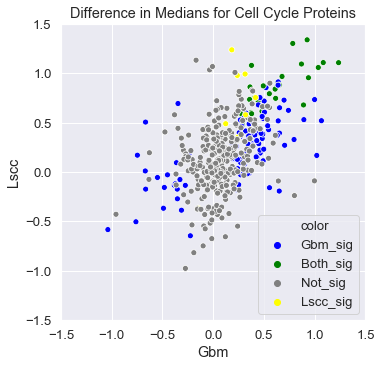

0

In [20]:
ut.binary_val_plot(plot_df,'corr','Gbm', 'Lscc','Difference in Medians for Cell Cycle Proteins',
                hue_col = 'color', color_dict = dict_in)